In [1]:
import numpy as np
import scipy as sci
import eddington
import os
import pickle
from matplotlib import pyplot as plt
import matplotlib as mpl
from bisect import bisect
import pandas as pd
plt.rcParams['figure.figsize'] = [20,10]
plt.rcParams.update({'font.size': 18, 'font.weight':'bold'})
plt.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [14]:
dres = [r'Measurements/Angle Calibration/', r'Measurements/Part I/', r'Measurements/Part II/']
picks = ['ang', 'rod', 'sci']
for i in range(len(dres)):
    dre = dres[i]
    data = []
    angs = []
    live=[]
    for file in sorted(os.listdir(dre), key=lambda x: x[5:-4]):
        if file[-3:]=='mca':
            with open(dre+file, 'rb') as f:
                values = str(f.read()).split('\\r\\n')
                live.append(float(values[8][11:]))
                values = values[values.index('<<DATA>>')+1:values.index('<<END>>')-1]
            values = np.array([int(val) for val in values])
    
            if len(angs)>0 and file[3:-6] not in ['','-'] and int(file[3:-6]) in angs:
                idx = angs.index(int(file[3:-6]))
                values = values + data[idx]
                data[idx] = values
            else:
                angs.append(int(file[3:-4]))
                data.append(values)
            
    data = [dt for _, dt in sorted(zip(angs, data))]
    angs = sorted(angs)

    with open(brn+picks[i]+'.pickle', 'wb') as f:
        pickle.dump([angs,data,np.array(live)], f)

In [8]:
dre = r'Measurements/Channel Calibration/'
data = []
name = []
for file in os.listdir(dre):
    if file[-3:]=='mca':
        with open(dre+file, 'rb') as f:
            values = str(f.read()).split('\\r\\n')
            values = values[values.index('<<DATA>>')+1:values.index('<<END>>')-1]
        values = np.array([int(val) for val in values])
        if len(name)>0 and name[-1]==r'$^{\boldsymbol{' + file[2:-4]+'-2}}$' + file[0].capitalize() + file[1]:
            name [-1] = r'$^{\boldsymbol{' + file[2:-4]+'}}$' + file[0].capitalize() + file[1]
            values = values + data[-1]
            data[-1] = values
        else:
            name.append(r'$^{\boldsymbol{' + file[2:-4]+'}}$' + file[0].capitalize() + file[1])
            data.append(values)

with open(brn+'chnnl.pickle', 'wb') as f:
    pickle.dump([name,data], f)

In [2]:
brn = r'Measurements/Brine/'

with open(brn+'ang.pickle', "rb") as f:
    ang, angData,live = pickle.load(f)
    
with open(brn+'chnnl.pickle', "rb") as f:
    name, chnnlData = pickle.load(f)
    
with open(brn+'mu.pickle', "rb") as f:
    mu, muNames, chnnls, ranges, ns = pickle.load(f)
    
with open(brn+'rod.pickle', "rb") as f:
    stAng, stAngData,livest = pickle.load(f) # Data of first part, structured as
                                      # stAng = [Angles], stAngData = [HistForFirstAngle, HistForSecondAngle,...]

with open(brn+'sci.pickle', "rb") as f:
    ndAng, ndAngData,livend = pickle.load(f) # Data of second part, same structure

In [3]:
def FWHM(x,y,index,frac,direction=0):
    value = y[index]*frac
    i = index
    while y[i]>value and i<len(y):
        i+=1
    rIndex=i
    i = index
    while y[i]>value and i>0:
        i-=1
    lIndex=i
    if direction == 0:
        return [(x[rIndex]-x[lIndex])/np.sqrt(8*np.log(1/frac)),lIndex,rIndex]
    if direction == 1:
        return [2*(x[rIndex]-x[index])/np.sqrt(8*np.log(1/frac)),index,rIndex]
    if direction == -1:
        return [2*(x[index]-x[lIndex])/np.sqrt(8*np.log(1/frac)),lIndex,index]
    
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def linFit(x,y,num):
    linData = eddington.FittingData(dict(x = np.hstack((x[:num],x[-num:])), dx = np.hstack((x[:num],x[-num:]))*0.05,
                                     y = np.hstack((y[:num],y[-num:])), dy = np.hstack((y[:num],y[-num:]))*0.05))
    return eddington.fit(linData, eddington.linear)

def expFit(x,y,num):
    linData = eddington.FittingData(dict(x = np.hstack((x[:num],x[-num:])), dx = np.hstack((x[:num],x[-num:]))*0.05,
                                     y = np.hstack((y[:num],y[-num:])), dy = np.hstack((y[:num],y[-num:]))*0.05))
    b1 = np.log(y[-1]/y[-5])/(x[-5]-x[-1])
    b0 = y[-1]/(np.exp(-b1*x[-1]))
    return eddington.fit(linData, expBKG, a0=[b0,b1])

def zerosFromId(y,idx):
    zeros = np.argwhere(y==0)
    bsct = bisect(zeros,idx)
    return [zeros[bsct],zeros[bsct+1]]

def Histogram(x,y,binSize):
    exc = len(y)%binSize
    if exc == 0:
        newY = np.sum(np.reshape(y,(-1,binSize)), axis=1)
        newX = np.sum(np.reshape(x,(-1,binSize)), axis=1)/binSize
    else:
        newY = np.sum(np.reshape(y[exc//2:-exc//2],(-1,binSize)), axis=1)
        newX = np.sum(np.reshape(x[exc//2:-exc//2],(-1,binSize)), axis=1)/binSize
    return newX, newY

def firstDerivative(x,y,lins,num=5):
    return (x[(lins+num)//2:-(lins+num)//2+lins%2],
            moving_average(np.array([linFit(x[i+1:i+1+lins],y[i+1:i+1+lins],2).a[1] for i in range(len(y)-lins+1)]),num))

def FitGaussWithBKG(x,y,BKG,index,frac,direction=0):
    sApprox = FWHM(x,y-BKG,index,frac,direction) # [sigma, rIndex, lIndex]
    if direction==0:
        muIdx = (sApprox[1]+sApprox[2])//2
    else:
        muIdx = index
    n=(y-BKG)[muIdx]*(sApprox[0]*np.sqrt(2*np.pi))
    ytag = (y-BKG)[sApprox[1]:sApprox[2]]
    gssData = eddington.FittingData(dict(x=x[sApprox[1]:sApprox[2]], dx=np.full((sApprox[2]-sApprox[1],),1/np.sqrt(12)),
                                     y=ytag, dy=np.sqrt(ytag)))
    gssRe = eddington.fit(gssData, Gaussian, a0=[n,sApprox[0],x[muIdx]])
    return gssRe

In [4]:
@eddington.fitting_function(
    n=3,
    syntax="a[0]*(1+np.cos(2*(x-a[1])))")
def sortaCosine(a,x):
    return a[0]*(1+np.cos(a[1]*(x-a[2])))

@eddington.fitting_function(
    n=4,
    syntax="a[0]*np.exp(-a[1]*x) + a[2]*x + a[3]")
def expLin(a,x):
    return a[0]*np.exp(-a[1]*x) + a[2]*x + a[3]

@eddington.fitting_function(
    n=3,
    syntax="a[0]*x**3/(np.exp(a[1]*x)-1) + a[2]")
def Planckian(a,x):
    return a[0]*x**3/(np.exp(a[1]*x)-1) + a[2]

@eddington.fitting_function(
    n=8,
    syntax="a[0]/(a[1]*np.sqrt(2*np.pi))*np.exp(-(x-a[2])**2/(2*a[1]**2)) +\
            a[3]/(a[4]*np.sqrt(2*np.pi))*np.exp(-(x-a[5])**2/(2*a[4]**2)) + a[6]*x + a[7]")
def twoGaussLin(a,x):
    return  a[0]/(a[1]*np.sqrt(2*np.pi))*np.exp(-(x-a[2])**2/(2*a[1]**2)) +\
            a[3]/(a[4]*np.sqrt(2*np.pi))*np.exp(-(x-a[5])**2/(2*a[4]**2)) + a[6]*x + a[7]


@eddington.fitting_function(
    n=5,
    syntax="a[0]/(a[1]*np.sqrt(2*np.pi))*np.exp(-(x-a[2])**2/(2*a[1]**2)) + a[3]*x + a[4]")
def Gauss(a,x):
    return a[0]/(a[1]*np.sqrt(2*np.pi))*np.exp(-(x-a[2])**2/(2*a[1]**2)) + a[3]*x + a[4]

@eddington.fitting_function(
    n=3,
    syntax="a[0]/(a[1]*np.sqrt(2*np.pi))*np.exp(-(x-a[2])**2/(2*a[1]**2))")
def Gaussian(a,x):
    return a[0]/(a[1]*np.sqrt(2*np.pi))*np.exp(-(x-a[2])**2/(2*a[1]**2))

@eddington.fitting_function(
    n=14,
    syntax="a[0]/(a[1]*np.sqrt(2*np.pi))*np.exp(-(x-a[2])**2/(2*a[1]**2)) +\
            a[3]/(a[4]*np.sqrt(2*np.pi))*np.exp(-(x-a[5])**2/(2*a[4]**2)) +\
            a[6]/(a[7]*np.sqrt(2*np.pi))*np.exp(-(x-a[8])**2/(2*a[7]**2)) +\
            a[9]/(a[10]*np.sqrt(2*np.pi))*np.exp(-(x-a[11])**2/(2*a[10]**2)) + a[12]*x + a[13]")
def fourGauss(a,x):
    return  a[0]/(a[1]*np.sqrt(2*np.pi))*np.exp(-(x-a[2])**2/(2*a[1]**2)) +\
            a[3]/(a[4]*np.sqrt(2*np.pi))*np.exp(-(x-a[5])**2/(2*a[4]**2)) +\
            a[6]/(a[7]*np.sqrt(2*np.pi))*np.exp(-(x-a[8])**2/(2*a[7]**2)) +\
            a[9]/(a[10]*np.sqrt(2*np.pi))*np.exp(-(x-a[11])**2/(2*a[10]**2)) + a[12]*x + a[13]

@eddington.fitting_function(
    n=8,
    syntax="a[0]/(a[1]*np.sqrt(2*np.pi))*np.exp(-(x-a[2])**2/(2*a[1]**2)) +\
            a[3]/(a[4]*np.sqrt(2*np.pi))*np.exp(-(x-a[5])**2/(2*a[4]**2)) + a[6]*np.exp(-a[7]*x)")
def twoGauss(a,x):
    return  a[0]/(a[1]*np.sqrt(2*np.pi))*np.exp(-(x-a[2])**2/(2*a[1]**2)) +\
            a[3]/(a[4]*np.sqrt(2*np.pi))*np.exp(-(x-a[5])**2/(2*a[4]**2)) + a[6]*np.exp(-a[7]*x)


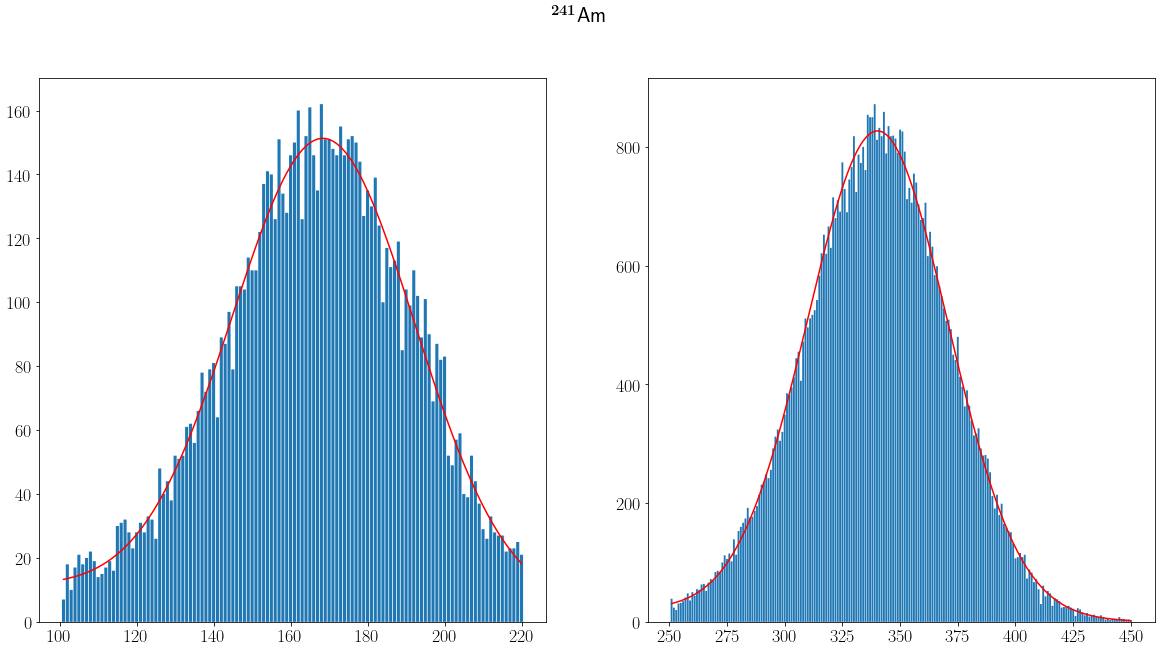

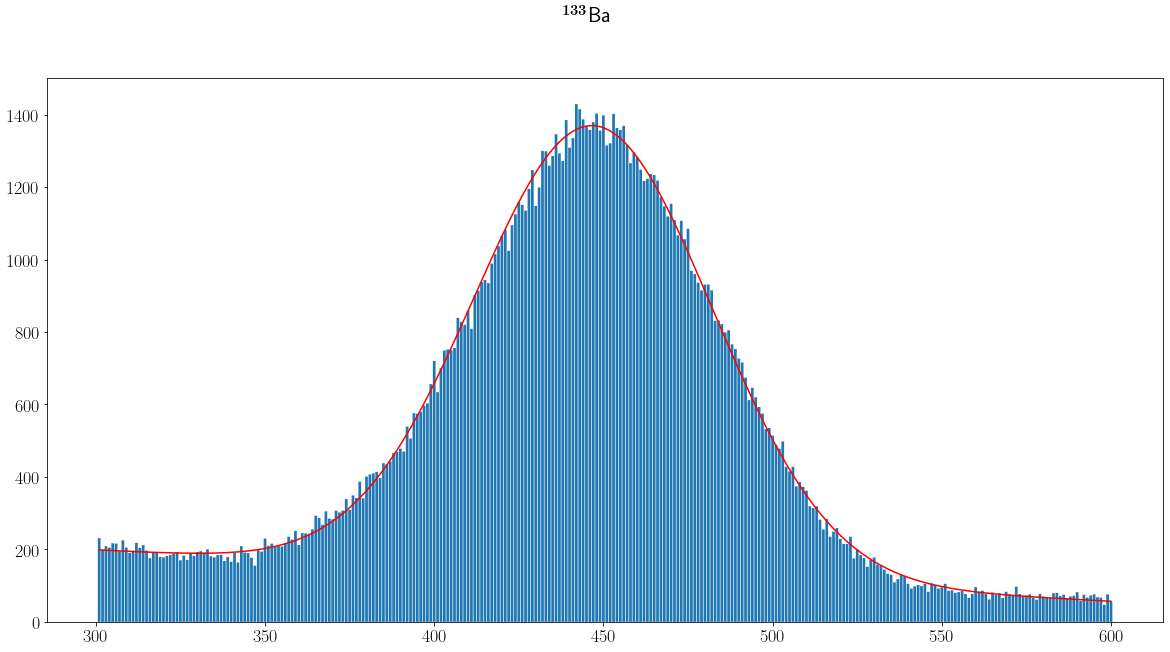

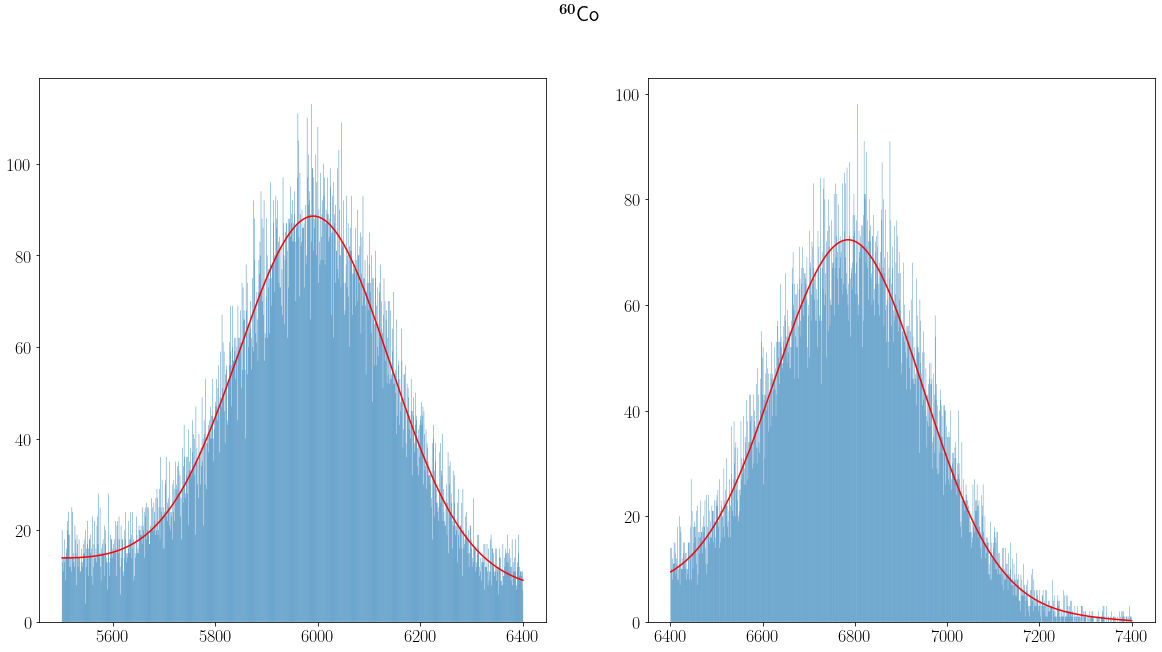

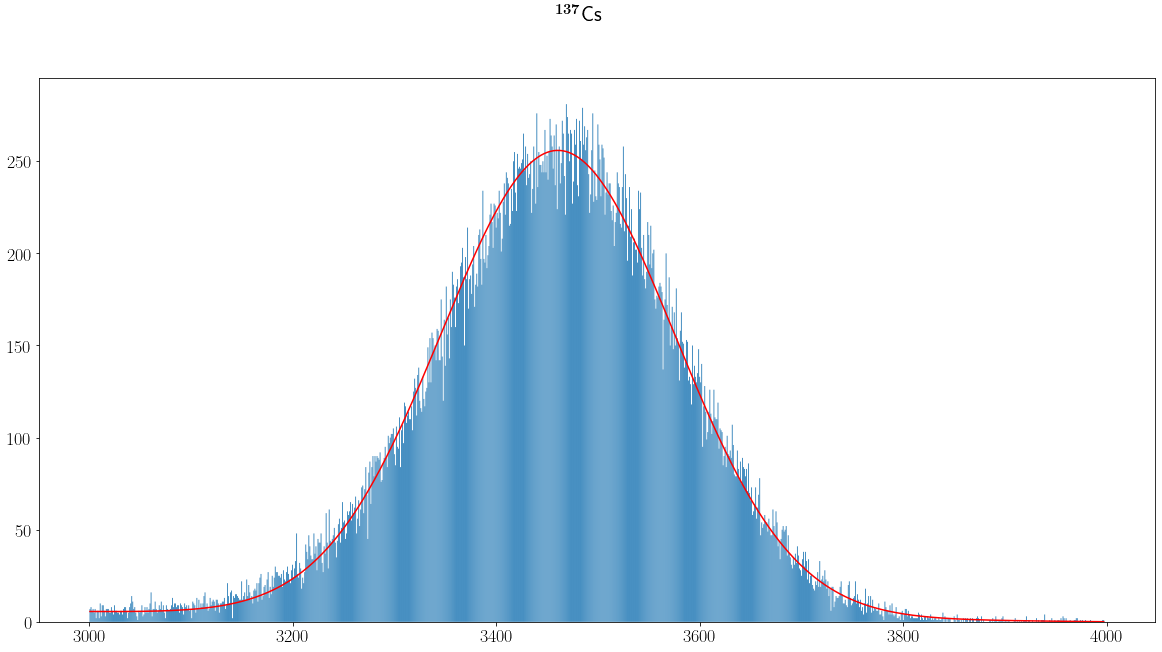

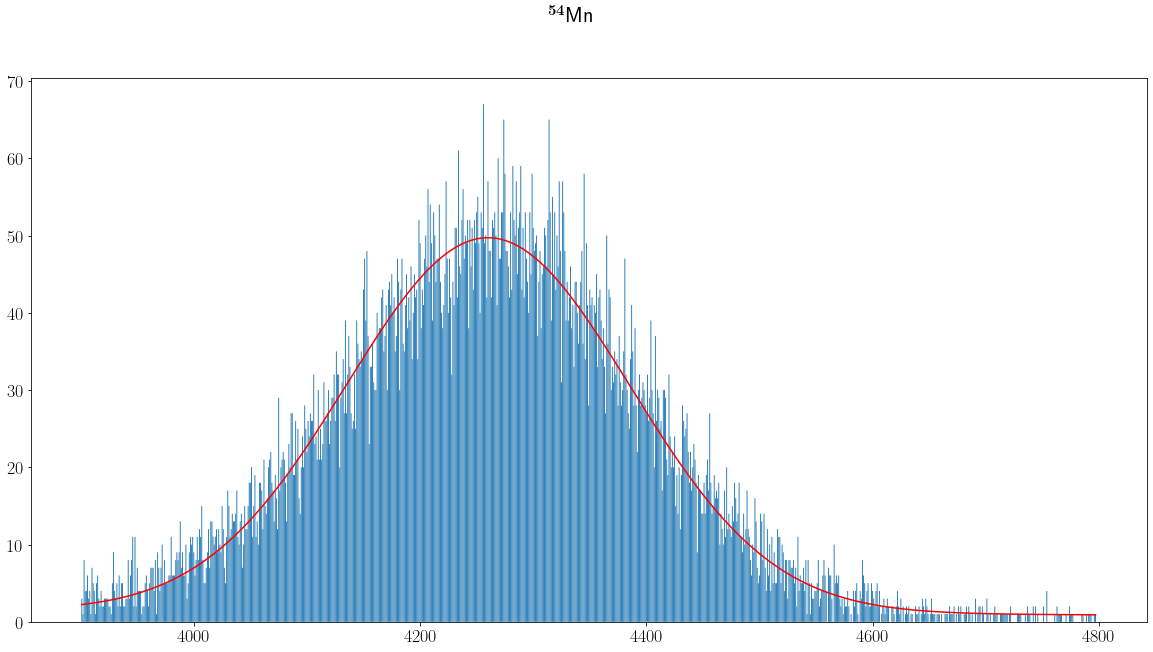

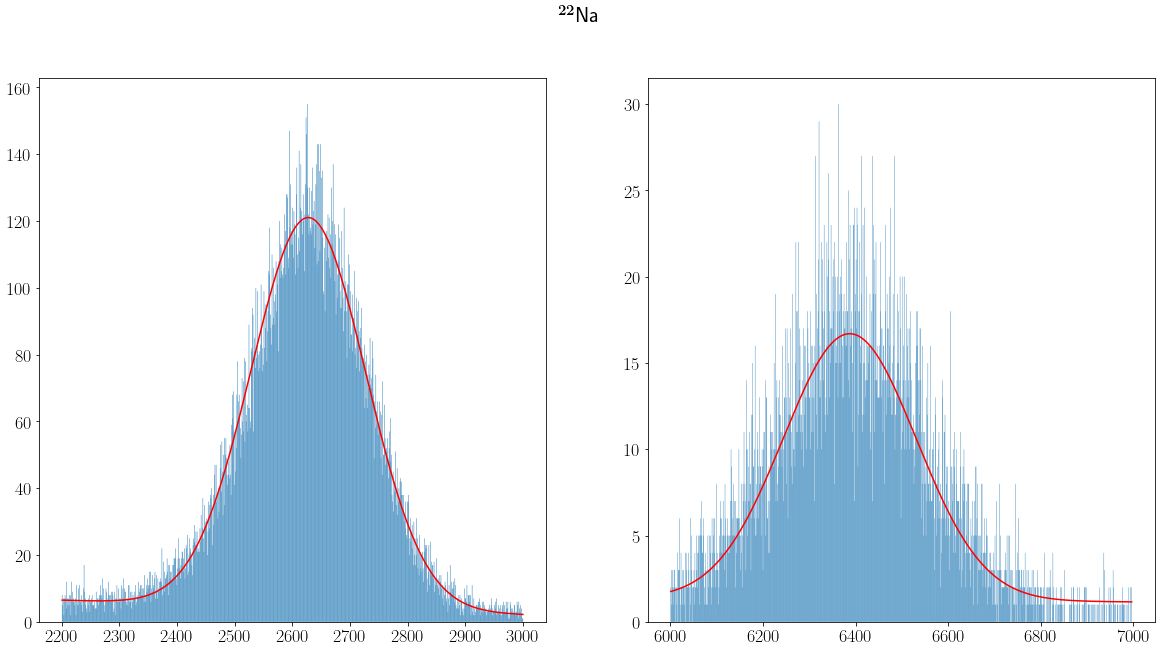

In [64]:
chnnls = list(range(1,len(chnnlData[0])+1))
ranges = [[[100,220,26.3448,2, 2.40, 2], [250,450,59.5412,2, 35.9, 4]], # Am241
          [[300,600,80.9971,14, 34.06, 27]], # Ba133 - 4 Gaussians in [1300,2200]
          [[5500,6400,1173.237,4, 99.9736, 7], [6400,7400,1332.501,5, 99.9856, 4]], # Co60
          [[3000,4000,661.657,3, 85.1, 2]], # Cs137
          [[3900,4800,834.848,3, 99.976, 1]], # Mn54
          [[2200,3000,510.9989275,3*10**(-8), None, None], [6000,7000,1274.53,2, 99.944, 14]]] # Na22

mu = []
ns = []
num = 5
for i in range(len(chnnlData)):
    fig, ax = plt.subplots(1, len(ranges[i]))
    ns.append([])
    if len(ranges[i])>1:
        for j in range(len(ranges[i])):
            rng = ranges[i][j]
            x = np.array(chnnls[rng[0]:rng[1]])
            y = np.array(chnnlData[i][rng[0]:rng[1]])
            x = x[y>0]
            y = y[y>0]
            linData = eddington.FittingData(dict(x = np.hstack((x[:num],x[-num:])), dx = np.hstack((x[:num],x[-num:]))*0.05,
                                                 y = np.hstack((y[:num],y[-num:])), dy = np.hstack((y[:num],y[-num:]))*0.05))
            linRe = eddington.fit(linData, eddington.linear)
            guess = [sum(y-eddington.linear(linRe.a,x)), # n
                     FWHM(x,y-eddington.linear(linRe.a,x),np.argmax(y-eddington.linear(linRe.a,x)),1/2)[0], # sigma
                     (rng[0]+rng[1])/2, # mu
                     linRe.a[1], # slope
                     linRe.a[0]] # const
            fitData = eddington.FittingData(dict(x = x, dx = np.full(x.size, 1/np.sqrt(12)), y = y, dy = np.sqrt(y)))
            re = eddington.fit(fitData, Gauss, a0=guess)
            mu.append([re.a[2],re.a[1]/np.sqrt(re.a[0]),rng[2],rng[2]*rng[3]/100,name[i]]) # [x,dx,y,dy]
            if rng[4] is not None:
                ns[-1].append([rng[2],rng[2]*rng[3]/100, re.a[0], re.aerr[0], rng[4],rng[4]*rng[5]/100]) # E dE n dn Ig dIg
            ax[j].bar(x,y,snap=False)
            ax[j].plot(x,Gauss(re.a,x),c='r')
    else:
        rng = ranges[i][0]
        x = np.array(chnnls[rng[0]:rng[1]])
        y = np.array(chnnlData[i][rng[0]:rng[1]])
        x = x[y>0]
        y = y[y>0]
        linData = eddington.FittingData(dict(x = np.hstack((x[:num],x[-num:])), dx = np.hstack((x[:num],x[-num:]))*0.05,
                                             y = np.hstack((y[:num],y[-num:])), dy = np.hstack((y[:num],y[-num:]))*0.05))
        linRe = eddington.fit(linData, eddington.linear)
        guess = [sum(y-eddington.linear(linRe.a,x)), # n
                 FWHM(x,y-eddington.linear(linRe.a,x),np.argmax(y-eddington.linear(linRe.a,x)),1/2)[0], # sigma
                 (rng[0]+rng[1])/2, # mu
                 linRe.a[1], # slope
                 linRe.a[0]] # const
        fitData = eddington.FittingData(dict(x = x, dx = np.full(x.size, 1/np.sqrt(12)), y = y, dy = np.sqrt(y)))
        re = eddington.fit(fitData, Gauss, a0=guess)
        mu.append([re.a[2],re.a[1]/np.sqrt(re.a[0]),rng[2],rng[2]*rng[3]/100,name[i]]) # [y,dy,x,dx]
        if rng[4] is not None:
            ns[-1].append([rng[2],rng[2]*rng[3]/100, re.a[0], re.aerr[0], rng[4],rng[4]*rng[5]/100]) # E dE n dn Ig dIg
        ax.bar(x,y,snap=False)
        ax.plot(x,Gauss(re.a,x),c='r')
        
    fig.suptitle(name[i])
    plt.savefig(r'Calibration Fits/' + name[i][15:-5] + name[i][-2:]+'_GaussFit.pdf')
    plt.show()

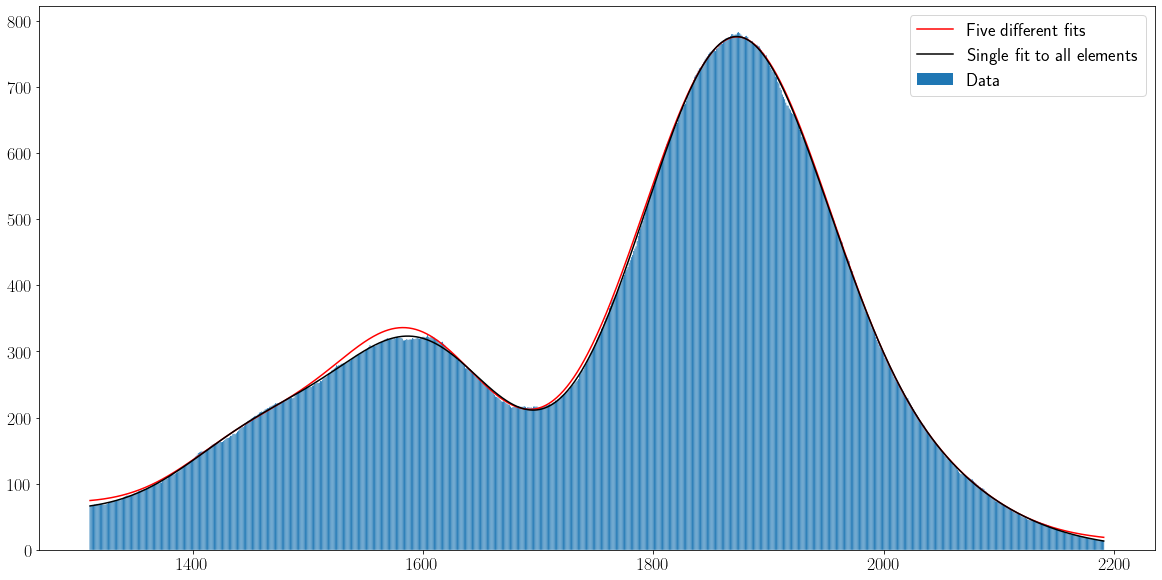

In [65]:
barium = r'$^{\boldsymbol{133}}$Ba'
num = 20
frac = 2/3
rng = [1300,2200]
engs = [1600.0*276.398/302.853,1600.0,1875.0,1875*383.851/356.017]
if len(ranges[1])==1:
    ranges[1] += [[1400, 1500, 276.398, 2, 7.164, 22],
                  [1500, 1700, 302.853, 1, 18.33, 6],
                  [1700, 1900, 356.017, 2, 62.05, 19],
                  [1900, 2200, 383.851, 3, 8.94, 3]]

x = np.array(chnnls[rng[0]+num//2:rng[1]-(num-1)//2])
y = moving_average(np.array(chnnlData[1][rng[0]:rng[1]]), num)
linData = eddington.FittingData(dict(x = np.hstack((x[:num],x[-num:])), dx = np.hstack((x[:num],x[-num:]))*0.05,
                                     y = np.hstack((y[:num],y[-num:])), dy = np.hstack((y[:num],y[-num:]))*0.05))
linRe = eddington.fit(linData, eddington.linear)

# Third peak is easiest
gssRe3 = FitGaussWithBKG(x, y, eddington.linear(linRe.a,x), np.argmax(y), frac)

# Fourth peak is next
gssRe4 = FitGaussWithBKG(x, y, eddington.linear(linRe.a,x)+Gaussian(gssRe3.a,x), bisect(x,engs[3]), frac)

# Then the second peak
gssRe2 = FitGaussWithBKG(x, y, eddington.linear(linRe.a,x)+Gaussian(gssRe3.a,x)+Gaussian(gssRe4.a,x),
                         bisect(x,engs[1]), frac,direction=1)
# Lastly the first peak
gssRe1 = FitGaussWithBKG(x, y, eddington.linear(linRe.a,x)+Gaussian(gssRe2.a,x)+Gaussian(gssRe3.a,x)+Gaussian(gssRe4.a,x),
                         bisect(x,engs[0]), frac)

plt.plot(x, Gaussian(gssRe1.a,x)+Gaussian(gssRe2.a,x)+\
         Gaussian(gssRe3.a,x)+Gaussian(gssRe4.a,x)+eddington.linear(linRe.a,x), c='r', label='Five different fits')

guess = [gssRe1.a[0],gssRe1.a[1],gssRe1.a[2],gssRe2.a[0],gssRe2.a[1],gssRe2.a[2],
         gssRe3.a[0],gssRe3.a[1],gssRe3.a[2],gssRe4.a[0],gssRe4.a[1],gssRe4.a[2], linRe.a[1], linRe.a[0]]
fitData = eddington.FittingData(dict(x = x, dx = np.full(x.size, 1/np.sqrt(12)), y = y, dy = np.sqrt(y)))
re = eddington.fit(fitData, fourGauss, a0=guess)

plt.plot(x, fourGauss(re.a,x), c='k', label='Single fit to all elements')
plt.bar(x, y, snap=False, label='Data')
plt.legend()
plt.savefig(r'Calibration Fits/133Ba_4GaussFit.pdf')
plt.savefig(r'Calibration Fits/133Ba_4GaussFit.png')
plt.show()

mu += [[re.a[2], re.a[1]/np.sqrt(re.a[0]), 276.398, 276.398*2/100, barium],
       [re.a[5], re.a[4]/np.sqrt(re.a[3]), 302.853, 302.853*1/100, barium],
       [re.a[8], re.a[7]/np.sqrt(re.a[6]), 356.017, 356.017*2/100, barium],
       [re.a[11], re.a[10]/np.sqrt(re.a[9]), 383.851, 383.851*3/100, barium]]
rng = ranges[1]
ns[1] += [[rng[1][2],rng[1][2]*rng[1][3]/100, re.a[0], re.aerr[0], rng[1][4],rng[1][4]*rng[1][5]/100],
          [rng[2][2],rng[2][2]*rng[2][3]/100, re.a[3], re.aerr[3], rng[2][4],rng[2][4]*rng[2][5]/100],
          [rng[3][2],rng[3][2]*rng[3][3]/100, re.a[6], re.aerr[6], rng[3][4],rng[3][4]*rng[3][5]/100],
          [rng[4][2],rng[4][2]*rng[4][3]/100, re.a[9], re.aerr[9], rng[4][4],rng[4][4]*rng[4][5]/100]]
mu = np.array(mu).T
ns = [np.array(en).T for en in ns]
muNames = np.array(mu[-1], dtype=str)
mu = np.array(mu[:-1], dtype='f')
with open(brn+'mu.pickle', 'wb') as f:
    pickle.dump([mu,muNames,chnnls,ranges,ns], f)

Results:

Initial parameters' values:
	1.0 1.0
Fitted parameters' values:
	a[0] = -7.0725 ± 0.3713 (5.249% error)
	a[1] = 1.971207e-1 ± 1.452e-4 (0.07368% error)
Fitted parameters covariance:
[[ 2.706e-01 -1.034e-04]
 [-1.034e-04  4.142e-08]]
Chi squared: 5.602
Degrees of freedom: 11
Chi squared reduced: 0.5093
P-probability: 0.8986



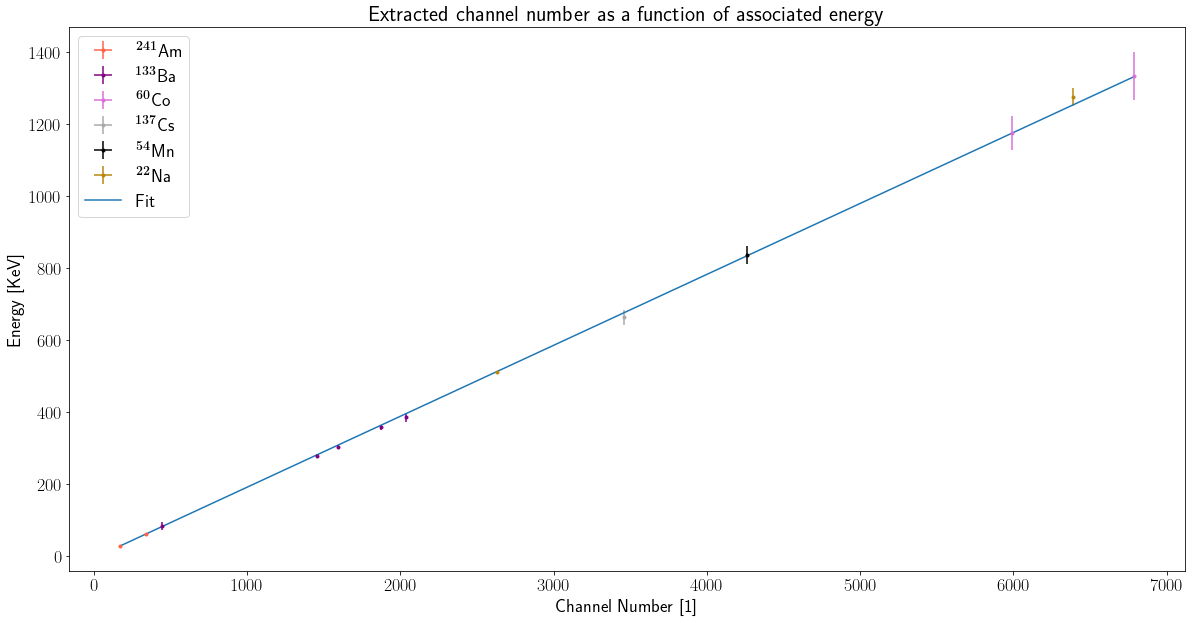

In [6]:
colored = []
plots = []
colors = np.array([[r'$^{\boldsymbol{133}}$Ba', 'purple'],
                   [r'$^{\boldsymbol{241}}$Am', 'tomato'],
                   [r'$^{\boldsymbol{60}}$Co', 'orchid'],
                   [r'$^{\boldsymbol{137}}$Cs', 'darkgrey'],
                   [r'$^{\boldsymbol{54}}$Mn', 'black'],
                   [r'$^{\boldsymbol{22}}$Na', 'darkgoldenrod']
                  ])
caliData = eddington.FittingData(dict(x=mu[0], dx=mu[1], y=mu[2], dy=mu[3]))
engCali = eddington.fit(caliData, eddington.linear)
engCali.save_txt(r'Calibration Fits/EnergyCalibrationLinear.txt')
print(engCali)
with open(brn+'EnergyChannel.pickle', 'wb') as f:
    pickle.dump(engCali, f)
x = np.linspace(min(mu[0]),max(mu[0]),num=200)
y = eddington.linear(engCali.a,x)
for i in range(len(mu[0])):
    if muNames[i] not in colors[:,0]:
        print(f'Error: {muNames[i]} not in colors')
    if muNames[i] not in colored:
        index = np.where(colors[:,0]==muNames[i])
        curves = plt.errorbar(x=mu[0][i],xerr=mu[1][i],y=mu[2][i],yerr=mu[3][i], fmt='.', c=colors[index,1][0][0])
        colored.append(muNames[i])
        plots.append(curves)
    else:
        index = np.where(colors[:,0]==muNames[i])
        plt.errorbar(x=mu[0][i],xerr=mu[1][i],y=mu[2][i],yerr=mu[3][i], fmt='.', c=colors[index,1][0][0])
curves, = plt.plot(x, y, c='tab:blue')
colored.append('Fit')
plots.append(curves)
plt.ylabel('Energy [KeV]')
plt.xlabel('Channel Number [1]')
plt.legend(plots, colored, loc='upper left')
plt.title(r'Extracted channel number as a function of associated energy')
plt.savefig(r'Calibration Fits/EnergyCalibrationLinear.pdf')
plt.show()

Results:

Initial parameters' values:
	1.0 1.0
Fitted parameters' values:
	a[0] = 0.57076 ± 0.05453 (9.553% error)
	a[1] = -3.7309e-4 ± 6.536e-5 (17.52% error)
Fitted parameters covariance:
[[ 2.372e-04 -2.404e-07]
 [-2.404e-07  3.409e-10]]
Chi squared: 125.3
Degrees of freedom: 10
Chi squared reduced: 12.53
P-probability: 4.186e-22



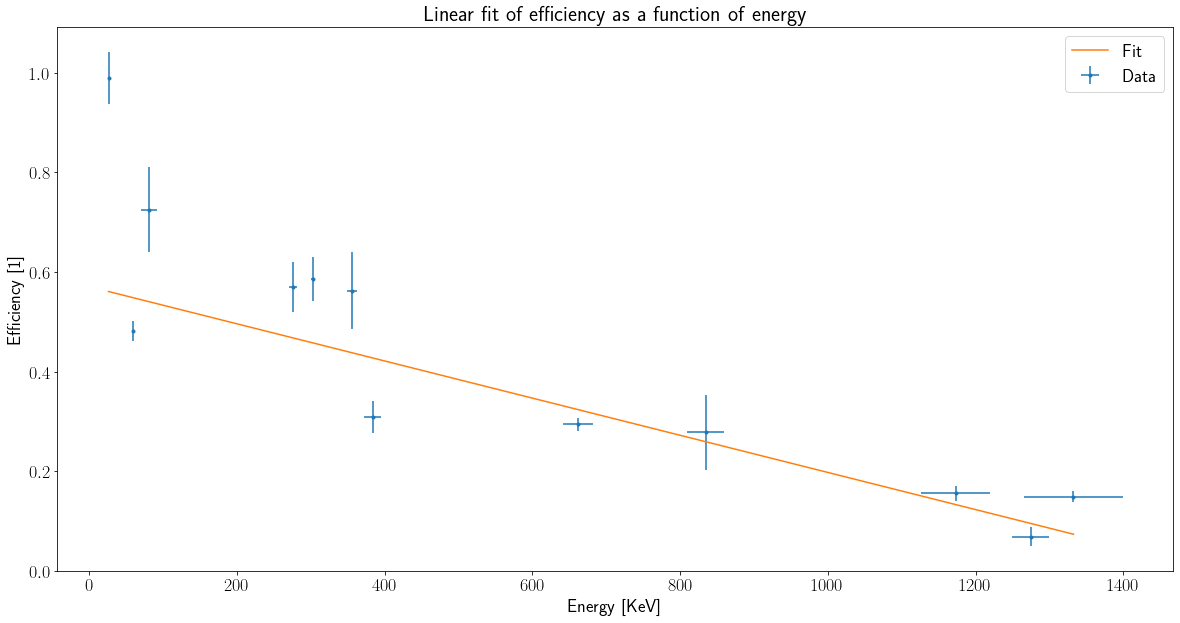

In [6]:
sDet = np.pi*(7.62/2)**2 # cm^2
consts = [ #A0 in [kBq], half life (yrs), t (yrs), Dt (sec), rDet (cm)
    [407, 432.2, 7, 2022-1973, 1/np.sqrt(12), 60, 15.1], # Am241
    [380, 10.51, 5, 2022-2004, 1/np.sqrt(12), 240, 15.1], # Ba133
    [370, 5.2714, 5, 2022-2017, 1/np.sqrt(12), 60, 15], # Co60, might be from 2017 with 370 or 1981 with 3700 or 1991 with 6290
    [407, 30.07, 3, 2022-2004, 1/np.sqrt(12), 60, 14.2], # Cs137
    [370, 312.3/365, 4, 2022-2018, 1/np.sqrt(12), 240, 15.2], # Mn54
    [376, 2.6019, 4, 2022-2004, 1/np.sqrt(12), 180, 5] # Na22
]
# ns structure is E dE n dn Ig dIg
eff = []
for i in range(len(ns)):
    NiN = ns[i][4]/100 * 1000*consts[i][0] * consts[i][5] * sDet/(4*np.pi*(consts[i][6])**2) * 2**(-consts[i][3]/consts[i][1])
    f = ns[i][2]/NiN
    df = np.sqrt((2*f/consts[i][6])**2/12 + (f*ns[i][5]/100)**2 + (f*ns[i][3]/ns[i][2])**2 +\
                 (f*np.log(2)/consts[i][1])**2/12 + (f*np.log(2)*consts[i][3]/consts[i][1] * consts[i][2]/100)**2)
    fs = [f, df, ns[i][0], ns[i][1]]
    if len(eff)==0:
        eff = np.array(fs)
    else:
        eff = np.hstack((eff,fs))
fitData = eddington.FittingData(dict(x=eff[2], dx=eff[3], y=eff[0], dy=eff[1]))
reLin = eddington.fit(fitData, eddington.linear)
reLin.save_txt('Calibration Fits/Efficiency.txt')
print(reLin)
plt.errorbar(x=eff[2], xerr=eff[3], y=eff[0], yerr=eff[1], fmt='.', label='Data')
x = np.linspace(min(eff[2]), max(eff[2]), num=1000)
plt.plot(x,eddington.linear(reLin.a,x), label='Fit')
plt.xlabel('Energy [KeV]')
plt.ylabel('Efficiency [1]')
plt.title('Linear fit of efficiency as a function of energy')
plt.legend()
plt.savefig('Calibration Fits/Efficiency.png')
plt.savefig('Calibration Fits/Efficiency.pdf')
plt.show()
with open(brn+'Efficiency.pickle', 'wb') as f:
    pickle.dump(reLin, f)

In [25]:
@eddington.fitting_function(
    n=3,
    syntax="a[0] + a[1]*(x-a[2])**2")
def SecondOrder(a,x):
    return a[0] + a[1]*(x-a[2])**2

Results:

Initial parameters' values:
	560000 2800000 -240000
Fitted parameters' values:
	a[0] = 5.72734e+5 ± 7.950e+3 (1.388% error)
	a[1] = 1.7852e+6 ± 1.084e+5 (6.073% error)
	a[2] = -8.5190e+6 ± 3.983e+5 (4.676% error)
Fitted parameters covariance:
[[ 5.785e+07 -6.920e+08  1.283e+09]
 [-6.920e+08  1.076e+10 -2.971e+10]
 [ 1.283e+09 -2.971e+10  1.452e+11]]
Chi squared: 4.370
Degrees of freedom: 4
Chi squared reduced: 1.093
P-probability: 0.3582

-0.10477550821209189


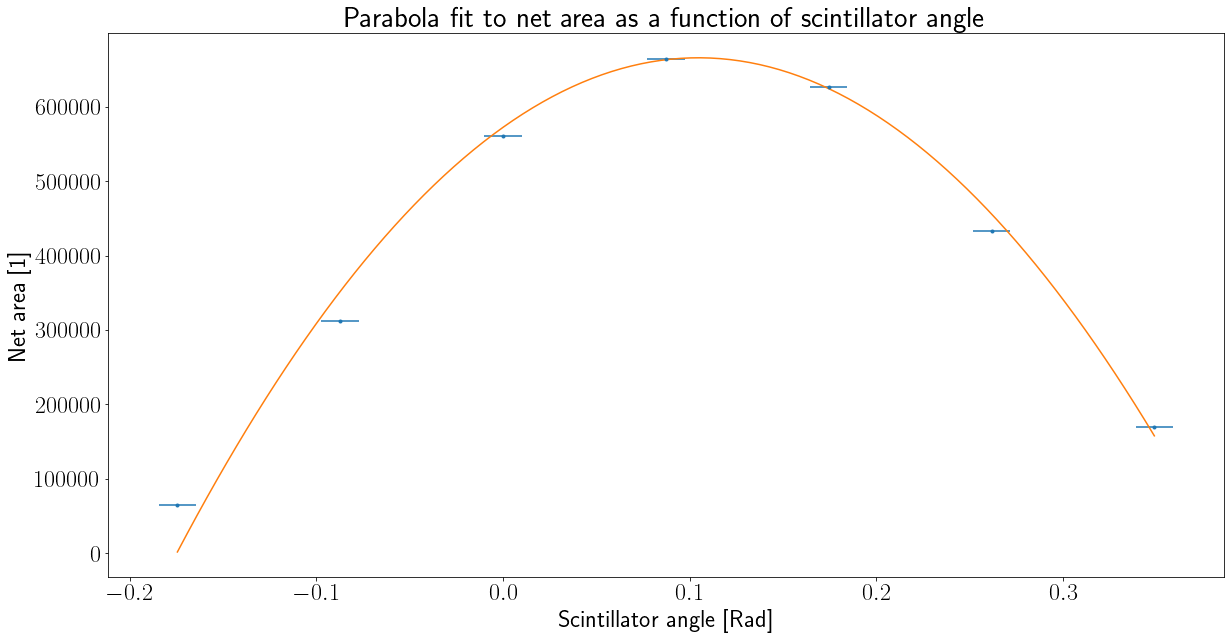

In [7]:
df = pd.read_excel('Measurements/Angle Calibration/angles.xlsx', skiprows=1).dropna(axis=1)
x = np.array(df['angle'])*np.pi/180
dx = np.full_like(x,2/np.sqrt(12))*np.pi/180
y = np.array(df['netArea'])
dy = 2*np.array(df['fwhm'])/np.sqrt(8*np.log(2))
data = eddington.FittingData(dict(x=x, dx=dx, y=y, dy=dy))
re = eddington.fit(data, eddington.polynomial(2), a0=[560000,2800000,-240000])
print(re)
print(re.a[1]/(2*re.a[2]))
re.save_txt('Calibration Fits/AngleCalibration.txt')
xs = np.linspace(min(x), max(x), num=100)
plt.rcParams.update({'font.size': 24, 'font.weight':'bold'})
plt.errorbar(x, y, xerr=dx, yerr=dy, fmt='.')
plt.plot(xs, eddington.polynomial(2)(re.a, xs))
plt.title(r'Parabola fit to net area as a function of scintillator angle')
plt.ylabel(r'Net area [1]')
plt.xlabel(r'Scintillator angle [Rad]')
plt.savefig(r'Calibration Fits/AngleCalibration.pdf')
plt.show()